In [1]:
import os
import json
import numpy as np
from quinine import QuinineArgumentParser
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import copy
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm

import sys
sys.path.append('../scripts')
from nano_gpt import GPT2Model, GPT2Config

from utils import eval_unlooped_model, aggregate_metrics, eval_looped_model


In [3]:
fig_hparam = {
    'figsize': (8, 5),
    'labelsize': 28,
    'ticksize': 20,
    'linewidth': 5,
    'fontsize': 15,
    'titlesize': 20,
    'markersize': 15
}

# font specification
fontdict = {'family': 'serif',
         'size': fig_hparam['fontsize'],
         }

In [4]:
import matplotlib.pyplot as plt
import matplotlib

def plot_errs(result_errs_agg):
    fig, ax = plt.subplots(1, figsize=fig_hparam['figsize'])

    err_result_dict_agg = result_errs_agg
    
    cmap = matplotlib.cm.get_cmap("coolwarm")
    result_name_list = list(result_errs_agg.keys())
    colors = cmap(np.linspace(0, 1, len(result_name_list)))
    for idx, model_name in enumerate(result_name_list):
        err = err_result_dict_agg[model_name]["mean"]
        ax.plot(err, color=colors[idx], lw=fig_hparam['linewidth'], label=model_name.capitalize())
        low = err_result_dict_agg[model_name]["bootstrap_low"]
        high = err_result_dict_agg[model_name]["bootstrap_high"]
        ax.fill_between(range(len(low)), low, high, alpha=0.3, color=colors[idx])
    
    ax.tick_params(axis='both', labelsize=fig_hparam['ticksize'])
    ax.axhline(1, color='k', ls='--', lw=fig_hparam['linewidth'])
    plt.rc('font', family='serif')
    ax.set_xlabel("in-context examples", fontsize=fig_hparam['labelsize'])
    y_label = ax.set_ylabel("squared error", fontsize=fig_hparam['labelsize'])
    legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fig_hparam['fontsize'])

In [5]:
device = torch.device('cuda:0')

In [6]:
def get_model(model, result_dir, run_id, step, best=False):
    if best:
        model_path = os.path.join(result_dir, run_id, 'model_best.pt')
        state_dict = torch.load(model_path, map_location='cpu')['state_dict']
        best_err = torch.load(model_path, map_location='cpu')['loss']
        print("saved model with loss:", best_err)
    if step == -1:
        model_path = os.path.join(result_dir, run_id, 'state.pt')
        state_dict = torch.load(model_path, map_location='cpu')['model_state_dict']
    else:
        model_path = os.path.join(result_dir, run_id, 'model_{}.pt'.format(step))
        state_dict = torch.load(model_path, map_location='cpu')['model']

    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict, strict=True)
    
    return model


## Get dataset

In [7]:
class LinearRegression():
    def __init__(self, batch_size, n_points, n_dims, n_dims_truncated, device, w_star=None):
        """scale: a constant by which to scale the randomly sampled weights."""
        super(LinearRegression, self).__init__()
        self.device = device
        self.xs = torch.randn(batch_size, n_points, n_dims, device=device)  # [B, n, d]
        self.xs[..., n_dims_truncated:] = 0
        w_b = torch.randn(batch_size, n_dims, 1, device=device)  # [B, d, 1]
        w_b[:, n_dims_truncated:] = 0
        self.w_b = w_b
        self.ys = (self.xs @ self.w_b).sum(-1)  # [B, n]
        
sample_size = 1280
batch_size = 128
n_points = 41
n_dims_truncated = 20
n_dims = 20

real_task = LinearRegression(sample_size, n_points, n_dims, n_dims_truncated, device)
xs, ys, w_b = real_task.xs, real_task.ys, real_task.w_b

## Эвалюация стандартного трансформера

In [8]:
result_dir = '../results2/linear_regression_baseline'
run_id = '0730153647-LR_baseline-43dc'

from models import TransformerModel

n_positions = 101
n_embd = 256
n_layer = 12
n_head = 8

model = TransformerModel(n_dims, n_positions, n_embd, n_layer, n_head)
step = -1
model = get_model(model, result_dir, run_id, step)
model = model.to(device)

err_default_transformer, y_pred_total = eval_unlooped_model(model, xs, ys)

number of parameters: 9.48M


In [9]:
result_errs = {}
result_errs['Transformer'] = err_default_transformer

# Эксперименты с Looped Transformer'ом

In [10]:
from models import TransformerModelLooped

result_dir = '../results2/linear_regression_loop'

def load_looped_by_runs(runs):
    result_errs = {}
    result_errs['Transformer'] = err_default_transformer
    
    n_positions = 101
    n_embd = 256
    n_head = 8
    T = 500
    
    for run in tqdm(runs.keys()):
        skip_connection = False
        if "skip_connection" in runs[run].keys():
            skip_connection = runs[run]["skip_connection"]
        use_ssm = False
        if "use_ssm" in runs[run].keys():
            use_ssm = runs[run]["use_ssm"]
        feed_block = False
        if "feed_block" in runs[run].keys():
            feed_block = runs[run]["feed_block"]
        n_tokens = 0
        if "n_tokens" in runs[run].keys():
            n_tokens = runs[run]["n_tokens"]
        model = TransformerModelLooped(n_dims, n_positions, n_embd, runs[run]["n_layer"], n_head, use_ssm=use_ssm, save_n_tokens=n_tokens, \
                                       feed_block=feed_block, skip_connection=skip_connection)
        step = -1
        if "step" in runs[run].keys():
            step = runs[run]["step"]
        model = get_model(model, result_dir, runs[run]["run_id"], step)
        model = model.to(device)
            
        err, loop_err = eval_looped_model(model, xs, ys, loop_max=T)
        
        result_errs[run] = err

    return result_errs

## Задание 1: сохранение последних N токенов

За удаление токенов отвечает параметр <code>save_n_tokens</code> модели. <br />
- <code>save_n_tokens</code> >= 1 означает "оставить n_layer токенов с конца"
- <code>save_n_tokens</code> < 0 означает "удалить -n_layer токенов с начала"
- 0 < <code>save_n_tokens</code> < 1 означает "оставить output.shape * n_layer токенов с конца"

  0%|                                                                                                                                   | 0/3 [00:00<?, ?it/s]

number of parameters: 0.79M


 33%|█████████████████████████████████████████                                                                                  | 1/3 [00:19<00:39, 20.00s/it]

number of parameters: 0.79M


 67%|██████████████████████████████████████████████████████████████████████████████████                                         | 2/3 [00:40<00:20, 20.02s/it]

number of parameters: 0.79M


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:00<00:00, 20.08s/it]


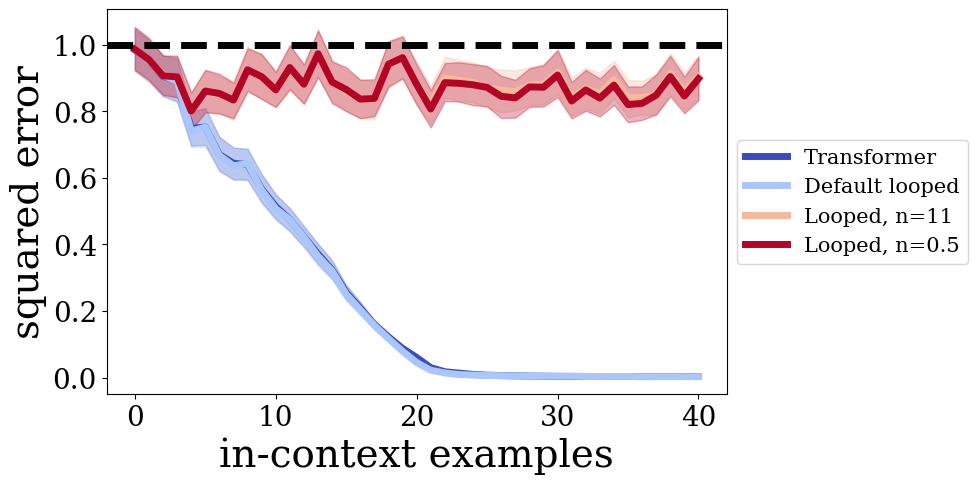

In [25]:
runs = {
        "Default looped": {"run_id": "0803162115-LR_loop_L1_ends{30}_T{15}-91e3", "n_layer": 1}, \
        "Looped, N=11": {"run_id": "0730183917-LR_loop_L1_ends{30}_T{15}_N{11}-08ea", "n_layer": 1, "n_tokens": 11}, \
        "Looped, N=0.5": {"run_id": "0731012201-LR_loop_L1_ends{30}_T{15}_N{0.5}-aa1f", "n_layer": 1, "n_tokens": 0.5}, \
       }

result_errs = load_looped_by_runs(runs)
result_errs_agg = aggregate_metrics(result_errs, n_dims_truncated)
plot_errs(result_errs_agg)

Как видно, если удалить слишком много токенов из output'а, модели становится сложно что-то выучить. <br />
Тогда будем удалять меньше токенов.

  0%|                                                                                                                                   | 0/5 [00:00<?, ?it/s]

number of parameters: 0.79M


 20%|████████████████████████▌                                                                                                  | 1/5 [00:21<01:26, 21.61s/it]

number of parameters: 0.79M


 40%|█████████████████████████████████████████████████▏                                                                         | 2/5 [00:43<01:05, 21.92s/it]

number of parameters: 0.79M


 60%|█████████████████████████████████████████████████████████████████████████▊                                                 | 3/5 [01:05<00:43, 21.91s/it]

number of parameters: 0.79M


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 4/5 [01:27<00:21, 21.96s/it]

number of parameters: 0.79M


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:49<00:00, 21.96s/it]


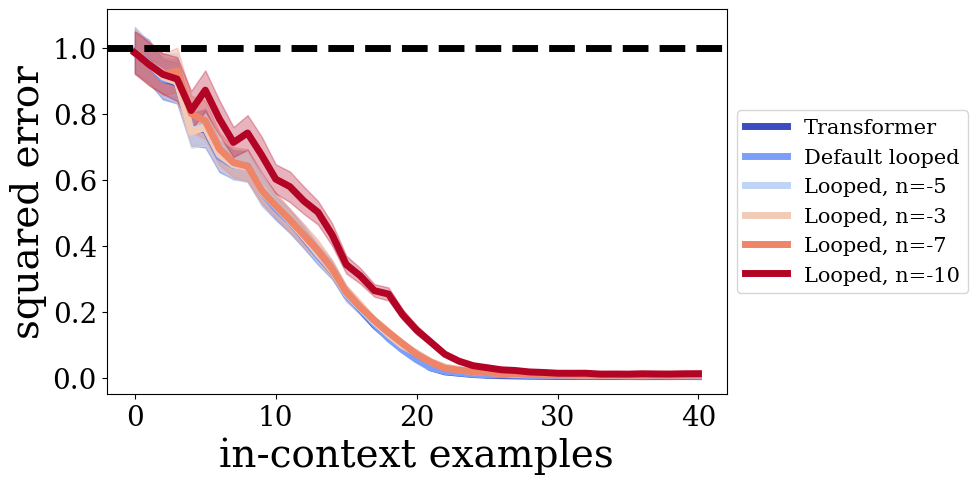

In [32]:
runs = {
        "Default looped": {"run_id": "0803162115-LR_loop_L1_ends{30}_T{15}-91e3", "n_layer": 1, "step": 80000}, \
        "Looped, N=-5": {"run_id": "0805015441-LR_loop_L1_ends{30}_T{15}_N{-5}-c40c", "n_layer": 1, "n_tokens": -5, "step": 80000}, \
        "Looped, N=-3": {"run_id": "0805015100-LR_loop_L1_ends{30}_T{15}_N{-3}-2d39", "n_layer": 1, "n_tokens": -3, "step": 80000}, \
        "Looped, N=-7": {"run_id": "0805012749-LR_loop_L1_ends{30}_T{15}_N{-7}-f037", "n_layer": 1, "n_tokens": -7, "step": 80000}, \
        "Looped, N=-10": {"run_id": "0805012838-LR_loop_L1_ends{30}_T{15}_N{-10}-9a65", "n_layer": 1, "n_tokens": -10, "step": 80000}, \
       }

result_errs = load_looped_by_runs(runs)
result_errs_agg = aggregate_metrics(result_errs, n_dims_truncated)
plot_errs(result_errs_agg)

Однако если удалять по 1-7 токенов из начала output'а, квадратичная ошибка на всех in-context примерах практически не проседает - таким образом, можно сэкономить эти неиспользуемые токены на, например, какую-нибудь дополнительную полезную информацию.

Такой результат объясняется тем, что количество используемых моделью токенов с каждой итерацией цикла растет (во всех моих моделях рост происходит с 22 до 82) - соответственно при удалении токенов из начала у модели все еще остается множество токенов с конца, которые она эффективно использует.

При этом скорость сходимости моделей остается такой же - они все достигают максимального качества примерно при 80k итераций.

  0%|                                                                                                                                   | 0/4 [00:00<?, ?it/s]

number of parameters: 0.79M


 25%|██████████████████████████████▊                                                                                            | 1/4 [00:39<01:58, 39.53s/it]

number of parameters: 0.79M


 50%|█████████████████████████████████████████████████████████████▌                                                             | 2/4 [01:20<01:20, 40.22s/it]

number of parameters: 0.79M


 75%|████████████████████████████████████████████████████████████████████████████████████████████▎                              | 3/4 [02:01<00:40, 40.86s/it]

number of parameters: 0.79M


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:43<00:00, 40.92s/it]


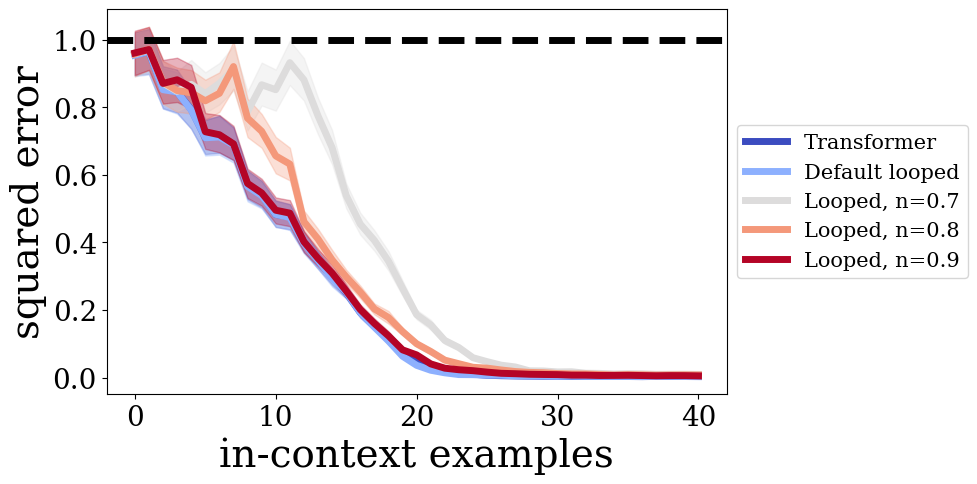

In [27]:
runs = {
        "Default looped": {"run_id": "0803162115-LR_loop_L1_ends{30}_T{15}-91e3", "n_layer": 1}, \
        "Looped, N=0.7": {"run_id": "0805013143-LR_loop_L1_ends{30}_T{15}_N{0.7}-3fdf", "n_layer": 1, "n_tokens": 0.7}, \
        "Looped, N=0.8": {"run_id": "0805135822-LR_loop_L1_ends{30}_T{15}_N{0.8}-3171", "n_layer": 1, "n_tokens": 0.8}, \
        "Looped, N=0.9": {"run_id": "0731105704-LR_loop_L1_ends{30}_T{15}_N{0.9}-ac48", "n_layer": 1, "n_tokens": 0.9}, \
       }

result_errs = load_looped_by_runs(runs)
result_errs_agg = aggregate_metrics(result_errs, n_dims_truncated)
plot_errs(result_errs_agg)

Если же оставлять только M% токенов с конца, то при n>0.8 качество сопоставимо с исходным, однако так получается сэкономить сильно меньше токенов; при n <= 0.7 качество заметно падает (это тоже связано с тем, что удаляем слишком много)

## Задание 2: looped n-layers

За количество слоев в цикле отвечает параметр <code>n_layer</code>. <br />
- если параметр <code>feed_block = False</code>, то слои идут друг за другом подряд внутри одной итерации цикла - без промежуточного "скармливания" исходного инпута
- если же параметр <code>feed_block = True</code>, то после каждого слоя к output'у добавляется исходный input (как в исходном looped transformer'e, только тут все слои разные)

Надпись (2) рядом с подписью к модели означает, что это такая же модель, обученная с другим random сидом для исключения случайности.

В этом разделе мы в основном будем изучать и сравнивать скорости сходимостей моделей.

  0%|                                                                                                                                   | 0/5 [00:00<?, ?it/s]

number of parameters: 0.79M


 20%|████████████████████████▌                                                                                                  | 1/5 [00:22<01:28, 22.07s/it]

number of parameters: 0.79M


 40%|█████████████████████████████████████████████████▏                                                                         | 2/5 [00:44<01:06, 22.10s/it]

number of parameters: 1.58M


 60%|█████████████████████████████████████████████████████████████████████████▊                                                 | 3/5 [01:23<00:59, 29.84s/it]

number of parameters: 1.58M


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 4/5 [02:02<00:33, 33.57s/it]

number of parameters: 3.16M


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:15<00:00, 39.16s/it]


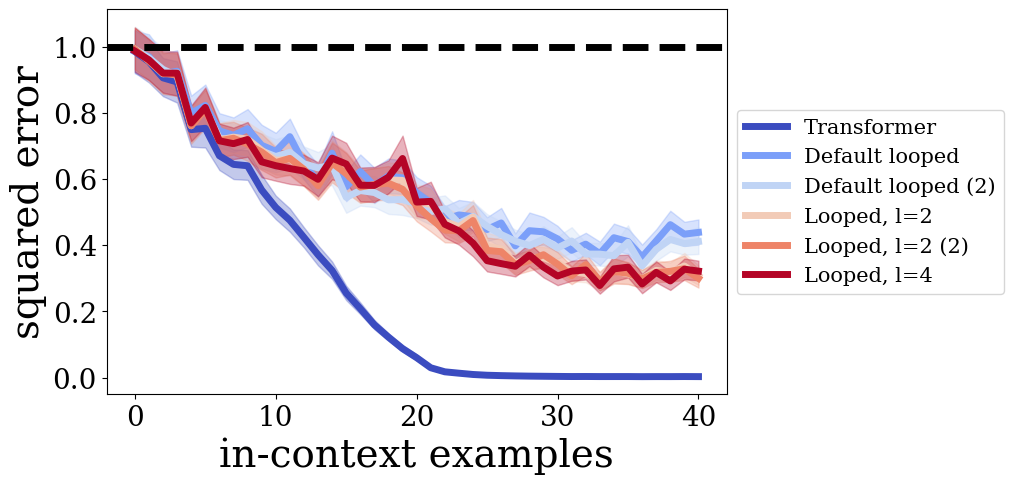

In [33]:
runs = {
        "Default looped": {"run_id": "0803162115-LR_loop_L1_ends{30}_T{15}-91e3", "n_layer": 1, "step": 70000}, \
        "Default looped (2)": {"run_id": "0731160704-LR_loop_L3_ends{30}_T{15}-764c", "n_layer": 1, "step": 70000}, \
        "Looped, L=2": {"run_id": "0731164711-LR_loop_L2_ends{30}_T{15}-d083", "n_layer": 2, "step": 70000}, \
        "Looped, L=2 (2)": {"run_id": "0803162021-LR_loop_L2_ends{30}_T{15}-7ecd", "n_layer": 2, "step": 70000}, \
        "Looped, L=4": {"run_id": "0804163507-LR_loop_L4_ends{30}_T{15}-0f3b", "n_layer": 4, "step": 70000}, \
       }

result_errs = load_looped_by_runs(runs)
result_errs_agg = aggregate_metrics(result_errs, n_dims_truncated)
plot_errs(result_errs_agg)

При 70k итерациях обучения заметен небольшой прирост качества у моделей с > 2 слоями на ~40 in-context примерах (в том числе на двух моделях с разными сидами).

  0%|                                                                                                                                   | 0/3 [00:00<?, ?it/s]

number of parameters: 0.79M


 33%|█████████████████████████████████████████                                                                                  | 1/3 [00:22<00:44, 22.41s/it]

number of parameters: 1.58M


 67%|██████████████████████████████████████████████████████████████████████████████████                                         | 2/3 [01:02<00:32, 32.83s/it]

number of parameters: 3.16M


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:17<00:00, 45.71s/it]


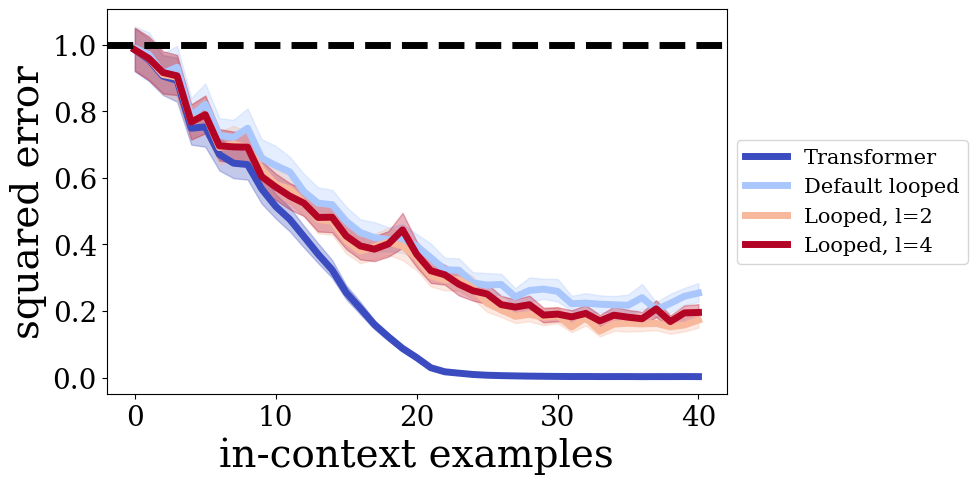

In [36]:
runs = {
        "Default looped": {"run_id": "0803162115-LR_loop_L1_ends{30}_T{15}-91e3", "n_layer": 1, "step": 75000}, \
        "Looped, L=2": {"run_id": "0803162021-LR_loop_L2_ends{30}_T{15}-7ecd", "n_layer": 2, "step": 75000}, \
        "Looped, L=4": {"run_id": "0804163507-LR_loop_L4_ends{30}_T{15}-0f3b", "n_layer": 4, "step": 75000}, \
       }

result_errs = load_looped_by_runs(runs)
result_errs_agg = aggregate_metrics(result_errs, n_dims_truncated)
plot_errs(result_errs_agg)

При 75k итераций же разрыв сокращается и становится малозначителен, к 80k итераций все модели сошлись. Вывод: модели с большим количеством слоев действительно сходятся быстрее, но эта разница в данном случае несущественна.

Причем разница в скорости сходимости между моделями с 2 и 4 слоями совсем отсутвует, при этом времени на обучение l=4 тратится кратно больше.

  0%|                                                                                                                                   | 0/5 [00:00<?, ?it/s]

number of parameters: 0.79M


 20%|████████████████████████▌                                                                                                  | 1/5 [00:26<01:44, 26.02s/it]

number of parameters: 0.79M


 40%|█████████████████████████████████████████████████▏                                                                         | 2/5 [00:50<01:14, 24.87s/it]

number of parameters: 1.58M


 60%|█████████████████████████████████████████████████████████████████████████▊                                                 | 3/5 [01:32<01:05, 32.70s/it]

number of parameters: 1.58M


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 4/5 [02:15<00:36, 36.84s/it]

number of parameters: 1.58M


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:39<00:00, 31.92s/it]


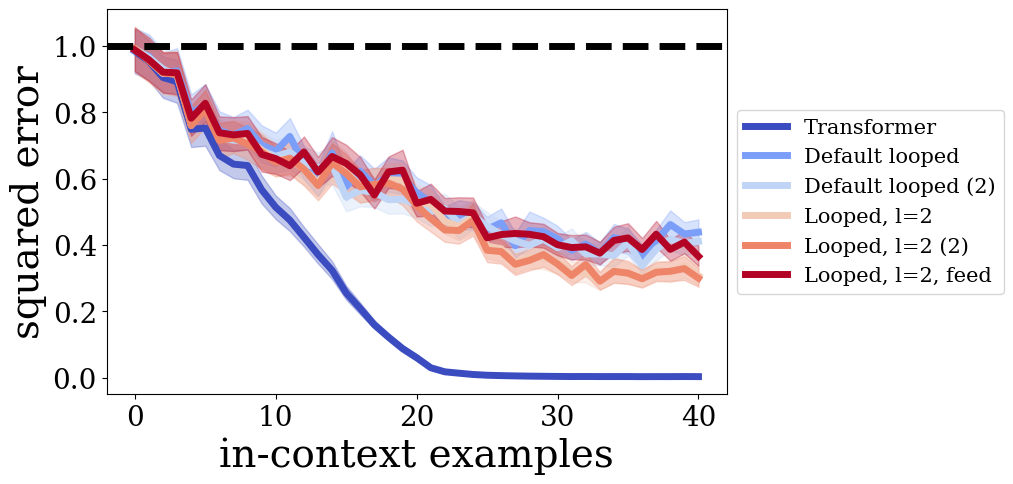

In [41]:
runs = {
        "Default looped": {"run_id": "0803162115-LR_loop_L1_ends{30}_T{15}-91e3", "n_layer": 1, "step": 70000}, \
        "Default looped (2)": {"run_id": "0731160704-LR_loop_L3_ends{30}_T{15}-764c", "n_layer": 1, "step": 70000}, \
        "Looped, L=2": {"run_id": "0731164711-LR_loop_L2_ends{30}_T{15}-d083", "n_layer": 2, "step": 70000}, \
        "Looped, L=2 (2)": {"run_id": "0803162021-LR_loop_L2_ends{30}_T{15}-7ecd", "n_layer": 2, "step": 70000}, \
        "Looped, L=2, feed": {"run_id": "0801140714-LR_loop_L2_ends{30}_T{15}_feed-431f", "n_layer": 2, "step": 70000, "feed_block": True}, \
       }

result_errs = load_looped_by_runs(runs)
result_errs_agg = aggregate_metrics(result_errs, n_dims_truncated)
plot_errs(result_errs_agg)

Параметр feed_block не дает зацикленным нескольким слоям никакого прироста в скорости сходимости. Думаю, это связано с тем, что при l=2 слоях исходный инпут и так добавляется довольно часто - соответственно модель его не "забывает" и можно не добавлять его еще раз.

## Задание 3: SSM

При <code>use_ssm=True</code> вместо Attention-блока в трансформере используется SSM-блок (с SSM'ом вместо self attention'a).

  0%|                                                                                                                                   | 0/1 [00:00<?, ?it/s]

number of parameters: 0.79M


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.59s/it]


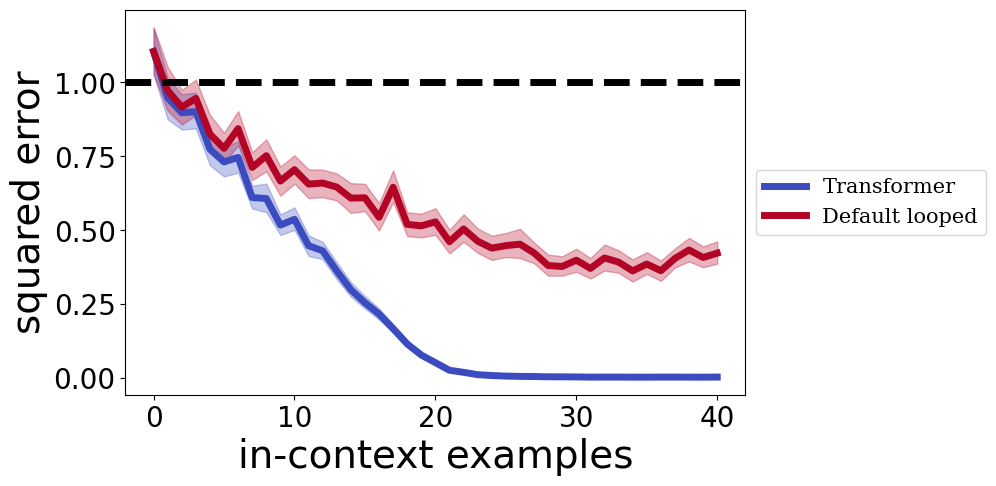

In [12]:
runs = {
        "Looped, ssm": {"run_id": "0803131927-LR_loop_L1_ends{30}_T{15}_ssm-ebc7", "n_layer": 1, "use_ssm": True}, \
        "Default looped": {"run_id": "0803162115-LR_loop_L1_ends{30}_T{15}-91e3", "n_layer": 1, "step": 70000}, \
       }

result_errs = load_looped_by_runs(runs)
result_errs_agg = aggregate_metrics(result_errs, n_dims_truncated)
plot_errs(result_errs_agg)

Модель совсем плохо выучилась и демонстрирует рост ошибки с увеличением in-context примеров. Это может быть связано как с наличием бага, так и с тем, что простая замена self attention'a на SSM может быть не очень полезна и что вместо этого стоит использовать такие современные и эффективные обертки над SSM как, например, Mamba.

## Bonus: skip-connections

В качестве бонуса я решил попробовать добавить в looped transformer skip connection'ы: по сути, просто добавлять к входным эмбеддингам не только предыдущий выход, но и предпредыщий. В перспективе эта дополнительная информация может быть немного полезна для модели, что может увеличить скорость сходимости.

За skip connection'ы отвечает параметр <code>skip_connection</code>.

Я решил экспериментировать со skip connection'ами в связке с параметром <code>n_tokens</code>: по сути, этот параметр экономит нам часть токенов, которые мы можем переиспользовать вот таким образом.

  0%|                                                                                                                                   | 0/4 [00:00<?, ?it/s]

number of parameters: 0.79M


 25%|██████████████████████████████▊                                                                                            | 1/4 [01:07<03:21, 67.15s/it]

number of parameters: 0.79M


 50%|█████████████████████████████████████████████████████████████▌                                                             | 2/4 [02:10<02:09, 64.77s/it]

number of parameters: 0.79M


 75%|████████████████████████████████████████████████████████████████████████████████████████████▎                              | 3/4 [03:13<01:04, 64.28s/it]

number of parameters: 0.79M


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:16<00:00, 64.19s/it]


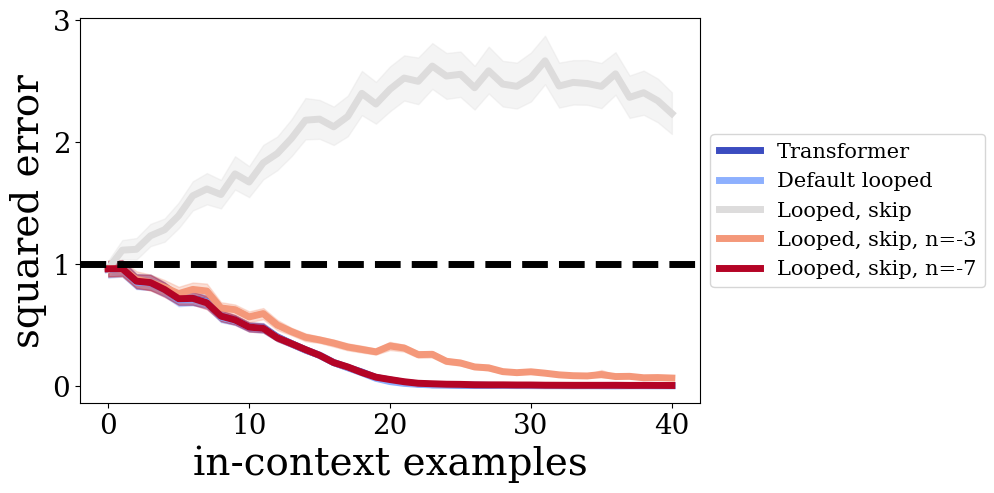

In [44]:
runs = {
        "Default looped": {"run_id": "0803162115-LR_loop_L1_ends{30}_T{15}-91e3", "n_layer": 1}, \
        "Looped, skip": {"run_id": "0805131259-LR_loop_L1_ends{30}_T{15}_skip-4455", "n_layer": 1, "skip_connection": True}, \
        "Looped, skip, N=-3": {"run_id": "0805131337-LR_loop_L1_ends{30}_T{15}_N{-3}_skip-8d5e", "n_layer": 1, \
                               "skip_connection": True, "n_tokens": -3}, \
        "Looped, skip, N=-7": {"run_id": "0805132432-LR_loop_L1_ends{30}_T{15}_N{-7}_skip-6103", "n_layer": 1, \
                               "skip_connection": True, "n_tokens": -7}, \
       }

result_errs = load_looped_by_runs(runs)
result_errs_agg = aggregate_metrics(result_errs, n_dims_truncated)
plot_errs(result_errs_agg)

По всей видимости, skip connection'ы совсем без удаления токенов из исходного output'а только зашумляют эмбеддинги и модель совсем не учится. <br />
При этом после удаления трех токенов с начала результат оказывается значительно лучше, однако модель не сходится до конца. Посмотрим поближе на результат с <code>N=-7</code> после 70k эпох обучения.

  0%|                                                                                                                                   | 0/3 [00:00<?, ?it/s]

number of parameters: 0.79M


 33%|█████████████████████████████████████████                                                                                  | 1/3 [00:42<01:24, 42.16s/it]

number of parameters: 0.79M


 67%|██████████████████████████████████████████████████████████████████████████████████                                         | 2/3 [01:23<00:41, 41.91s/it]

number of parameters: 0.79M


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:07<00:00, 42.44s/it]


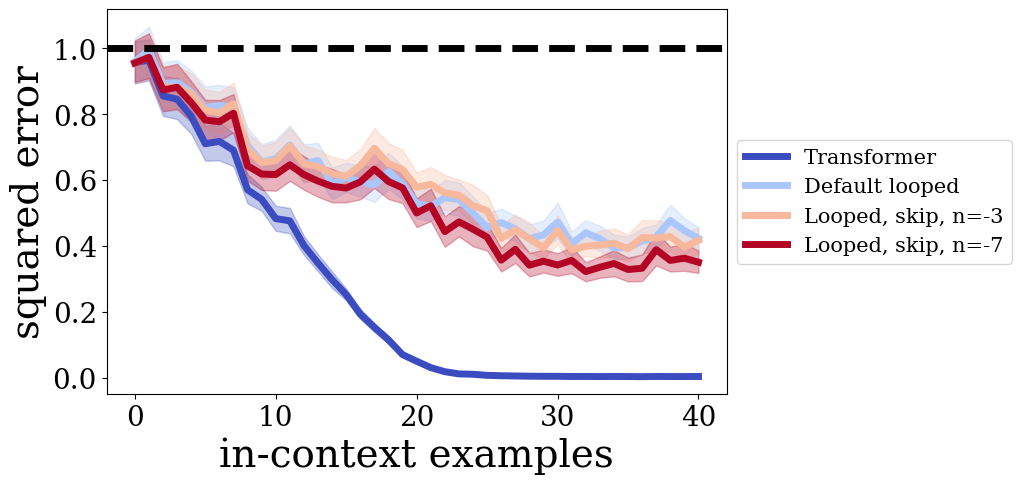

In [39]:
runs = {
        "Default looped": {"run_id": "0803162115-LR_loop_L1_ends{30}_T{15}-91e3", "n_layer": 1, "step": 70000}, \
        "Looped, skip, N=-3": {"run_id": "0805131337-LR_loop_L1_ends{30}_T{15}_N{-3}_skip-8d5e", "n_layer": 1, \
                               "skip_connection": True, "n_tokens": -3, "step": 70000}, \
        "Looped, skip, N=-7": {"run_id": "0805132432-LR_loop_L1_ends{30}_T{15}_N{-7}_skip-6103", "n_layer": 1, \
                               "skip_connection": True, "n_tokens": -7, "step": 70000}, \
       }

result_errs = load_looped_by_runs(runs)
result_errs_agg = aggregate_metrics(result_errs, n_dims_truncated)
plot_errs(result_errs_agg)

Как видно, модель сходится даже немного быстрее, чем исходная: думаю, это объясняется тем, что ей удалось эффективно переиспользовать эти 7 удаленных токенов с помощью skip соединения с предпредыдущим слоем. <br />
Я проводил эксперименты только с удалением 3 и 7 токенов из начала; это связано с тем, что 7 - максимальное полученное мной число удаляемых токенов, при котором качество модели без skip'ов сопоставимо с исходным (думаю, можно подобрать чуть более оптимальное число, но сути это не меняет)

  0%|                                                                                                                                   | 0/3 [00:00<?, ?it/s]

number of parameters: 0.79M


 33%|█████████████████████████████████████████                                                                                  | 1/3 [00:40<01:21, 40.65s/it]

number of parameters: 0.79M


 67%|██████████████████████████████████████████████████████████████████████████████████                                         | 2/3 [01:22<00:41, 41.49s/it]

number of parameters: 0.79M


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:05<00:00, 41.70s/it]


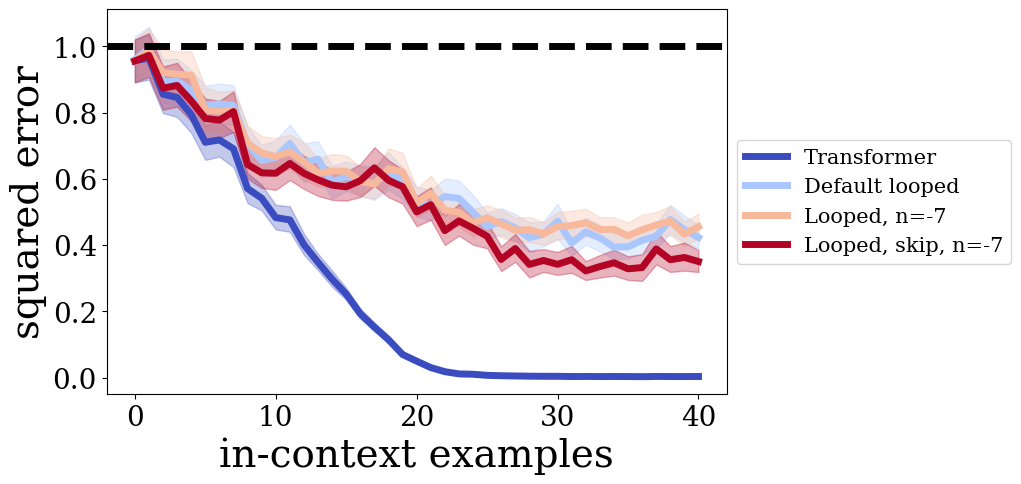

In [36]:
runs = {
        "Default looped": {"run_id": "0803162115-LR_loop_L1_ends{30}_T{15}-91e3", "n_layer": 1, "step": 70000}, \
        "Looped, N=-7": {"run_id": "0805012749-LR_loop_L1_ends{30}_T{15}_N{-7}-f037", "n_layer": 1, "n_tokens": -7, "step": 70000}, \
            "Looped, skip, N=-7": {"run_id": "0805132432-LR_loop_L1_ends{30}_T{15}_N{-7}_skip-6103", "n_layer": 1, \
                               "skip_connection": True, "n_tokens": -7, "step": 70000}, \
       }

result_errs = load_looped_by_runs(runs)
result_errs_agg = aggregate_metrics(result_errs, n_dims_truncated)
plot_errs(result_errs_agg)

Также заметно, что добавление skip'ов улучшает сходимость модели с n=-7

  0%|                                                                                                                                   | 0/3 [00:00<?, ?it/s]

number of parameters: 0.79M


 33%|█████████████████████████████████████████                                                                                  | 1/3 [01:07<02:15, 67.70s/it]

number of parameters: 0.79M


 67%|██████████████████████████████████████████████████████████████████████████████████                                         | 2/3 [02:07<01:03, 63.15s/it]

number of parameters: 1.58M


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:55<00:00, 78.43s/it]


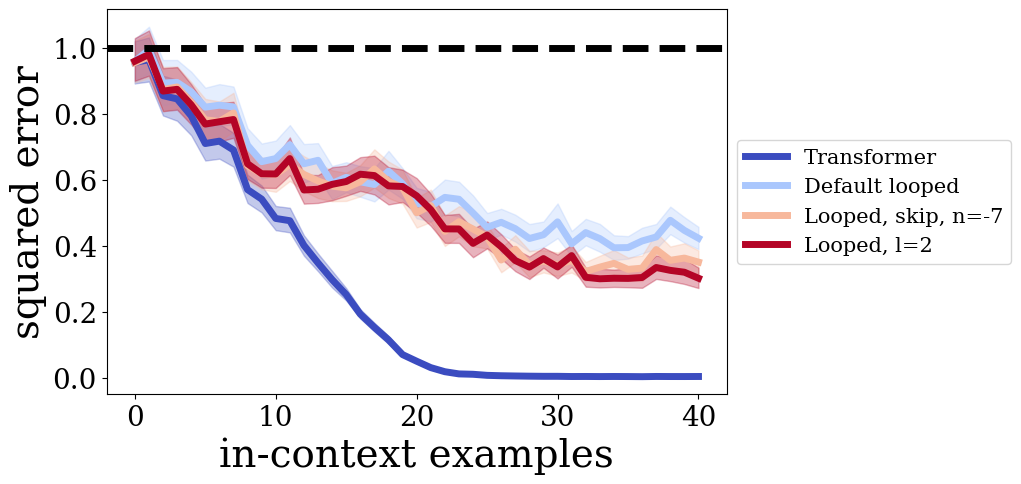

In [42]:
runs = {
        "Default looped": {"run_id": "0803162115-LR_loop_L1_ends{30}_T{15}-91e3", "n_layer": 1, "step": 70000}, \
        "Looped, skip, N=-7": {"run_id": "0805132432-LR_loop_L1_ends{30}_T{15}_N{-7}_skip-6103", "n_layer": 1, \
                               "skip_connection": True, "n_tokens": -7, "step": 70000}, \
        "Looped, L=2": {"run_id": "0803162021-LR_loop_L2_ends{30}_T{15}-7ecd", "n_layer": 2, "step": 70000}, \
       }

result_errs = load_looped_by_runs(runs)
result_errs_agg = aggregate_metrics(result_errs, n_dims_truncated)
plot_errs(result_errs_agg)

Однако по сравнению с l=2 моделью (looped transformer с 2 слоями) новая модель не так эффективна, хоть и тоже лучше дефолтной версии.